## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

In [2]:
from src.data_collection.multimodal_data import AudioDataset, MultimodalDataLoader, map_weights
from src.nlp.neural_model import MultiLinearDecoder, MultiModalPostRNN

### Model definitions
Define this notebooks "initializer model" (pretrained parameters and itos mapping) and the output model as well.

In [3]:
model_name = '4.3-MM-108k-post-genre-song_title'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

init_model_name = '4.2-LM-108k-lines-genre-song_title'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')
INIT_MODEL_PATH.mkdir(exist_ok=True)

### Tokenization and featurization
To create the model's tokens with the correct train-test split, run the code below. Only needed once on the notebook's first ever run.

In [4]:
MODEL_FIRST_RUN = True

In [5]:
def tokenize_lyrics_with_tags(lyrics, line_num=True, genre=False, song_title=False):
    tk = nltk.tokenize.LineTokenizer(blanklines='keep')
    tokd = tk.tokenize(lyrics)
    
    re_tk = nltk.tokenize.RegexpTokenizer(r'\[[^\]]+\]|\w+|[\d\.,]+|\S+',
                                          discard_empty=False)
    re_tokd = re_tk.tokenize_sents(tokd)

    if genre:
        [s.insert(0, f'xGENRE') for s in re_tokd] # insert start token for each line

    elif song_title:
        [s.insert(0, f'xTITLE') for s in re_tokd] # insert start token for each line

    else:
        if line_num:
            [s.insert(0, f'xBOL {line_num+1}') for line_num, s in enumerate(re_tokd)] # insert start token for each line
        else:
            [s.insert(0, f'xBOL') for s in re_tokd] # insert start token for each line

        [s.append('xEOL') for s in re_tokd] # append end token for each line

    flat = list(itertools.chain(*re_tokd))
    # lower case and de-space
    flat = [w.lower().replace(' ', '-') for w in flat]
    return flat

In [6]:
def process_tokens(model_path):
    '''
    500k link: https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv
    108k link: https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv
    '''
    model_path = Path(MODEL_PATH)
    model_path.mkdir(exist_ok=True)

    small_corpus_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv'
    audio_url = 'https://storage.googleapis.com/w210-capstone/data/msd-aggregate.csv'
    tag_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics_tags.csv'

    # load scraped data
    df = pd.read_csv(small_corpus_url,
                     header=None, escapechar='\\',
                     names=['msd_id', 'lyrics'])

    # only keep lyrics with length < 5000
    df = df[df.lyrics.str.len() < 5000]

    # bring in audio features
    df_audio = pd.read_csv(audio_url)
    df_audio.rename(columns={'track_id': 'msd_id'}, inplace=True)

    # bring in tags
    df_tags = pd.read_csv(tag_url, index_col=0)
    df_tags.drop(columns=['lyrics'], inplace=True)

    # match audio to keys from lyrics
    df_audio = pd.merge(df, df_audio, how='inner', on='msd_id')

    # mat
    df_all = pd.merge(df_audio, df_tags, how='inner', on='msd_id')
    df = df_all[['tag1', 'tag2', 'title', 'lyrics']]

    print('Tokenizing...')
    lyrics = df.lyrics.apply(tokenize_lyrics_with_tags, line_num=True)
    genre = df.tag1.astype(str).apply(tokenize_lyrics_with_tags, line_num=False, genre=True)
    song_title = df.title.apply(tokenize_lyrics_with_tags, line_num=False, song_title=True)

    full_song = (['xbos'] + genre + song_title + lyrics + ['xeos'])

    # split train/test
    df_train, df_test = train_test_split(full_song, test_size=0.2, random_state=2018)

    # tokens
    print('Saving...')
    tokens = np.array(df_train)
    np.save(model_path/'train_tok.npy', tokens)

    tokens = np.array(df_test)
    np.save(model_path/'valid_tok.npy', tokens)
    print('Done.')

In [7]:
def process_audio(model_path):
    '''
    500k link: https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv
    108k link: https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv
    '''
    model_path = Path(model_path)
    model_path.mkdir(exist_ok=True)
    
    small_corpus_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv'
    audio_url = 'https://storage.googleapis.com/w210-capstone/data/msd-aggregate.csv'
    tag_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics_tags.csv'
    
    df = pd.read_csv(small_corpus_url,
                 header=None, escapechar='\\',
                 names=['msd_id', 'lyrics'])
    
    # only keep lyrics with length < 5000
    df = df[df.lyrics.str.len() < 5000]
    
    # bring in audio features
    df_audio = pd.read_csv(audio_url)
    df_audio.rename(columns={'track_id': 'msd_id'}, inplace=True)
    
    # bring in tags
    df_tags = pd.read_csv(tag_url, index_col=0)
    df_tags.drop(columns=['lyrics'], inplace=True)
    
    # match audio to keys from lyrics
    df_audio = pd.merge(df, df_audio, how='inner', on='msd_id')
    
    # mat
    df_all = pd.merge(df_audio, df_tags, how='inner', on='msd_id')
    
    
    # split data using same seed as lm_data_lyrics.py
    df_train, df_valid = train_test_split(df_all,
                                         test_size=0.2,
                                         random_state=2018)
    
    df_train.to_csv(model_path/'df_train.csv')
    df_valid.to_csv(model_path/'df_valid.csv')
    
    return df_train, df_valid

In [8]:
if MODEL_FIRST_RUN:
    process_tokens(MODEL_PATH)

Tokenizing...
Saving...
Done.


In [9]:
if MODEL_FIRST_RUN:
    df_train, df_valid = process_audio(MODEL_PATH)

In [10]:
def log_features(X):
    return np.log(X)

def bin_tempo(X):
    '''
    ref: https://en.wikipedia.org/wiki/Tempo#Italian_tempo_markings
    These are rough loosely based on tempo markings above
    Have considered both classical forms of music and popular
    '''
    assert X.shape[1] == 1, "Only 1 column can be binned"
    bins = [0, 60, 76, 108, 120, 156, 176, 200, 500]
    return pd.DataFrame(pd.cut(X.iloc[:,0], bins=bins))
tempo_feat = FunctionTransformer(bin_tempo, validate=False)

def bin_time_signature(X):
    assert X.shape[1] == 1, "Only 1 column can be binned"
    X['time_signature_bin'] = "Other Signature"
    X.loc[X['time_signature'] == 4, 'time_signature_bin'] = '4/4 Signature'
    X.loc[X['time_signature'] == 3, 'time_signature_bin'] = '3/4 Signature'
    return X[['time_signature_bin']]

def to_string(X):
    return X.astype('str')

In [11]:
log_feat = FunctionTransformer(log_features, validate=False)
time_feat = FunctionTransformer(bin_time_signature, validate=False)

In [25]:
def create_preprocessor(df_train=None):
        
    # continous features
    numeric_features = ['loudness']
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # log features
    log_features = ['duration']
    log_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('log_feat', log_feat),
        ('scaler', StandardScaler())
    ])

    # categorical features
    categorical_features = ['key', 'mode']
    categorical_transformer = Pipeline(steps=[
        ('stringify', FunctionTransformer(to_string, validate=False)),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(sparse=False))
    ])

    # time signature feature
    time_feature = ['time_signature']
    time_transformer = Pipeline(steps=[
        ('binner', time_feat),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('stringify', FunctionTransformer(to_string, validate=False)),
        ('onehot', OneHotEncoder(sparse=False))
    ])

    # tempo feature
    tempo_feature = ['tempo']
    tempo_transformer = Pipeline(steps=[
        ('binner', tempo_feat),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('stringify', FunctionTransformer(to_string, validate=False)),
        ('onehot', OneHotEncoder(sparse=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('log', log_transformer, log_features),
            ('cat', categorical_transformer, categorical_features),
            ('time', time_transformer, time_feature),
            ('tempo', tempo_transformer, tempo_feature)
        ],
        remainder='drop'
    )
    
    preprocessor.fit(df_train)
    return preprocessor

## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [26]:
if MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                          bs=128,
                                          max_vocab=20000)

In [27]:
if not MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_id_files(MODEL_PATH/'tmp')
    data_lm.path = MODEL_PATH

In [28]:
data_lm.train_ds.vocab_size

20002

In [29]:
train_text = copy(data_lm.train_ds)
valid_text = copy(data_lm.valid_ds)

In [30]:
if not MODEL_FIRST_RUN:
    df_train = pd.read_csv(MODEL_PATH/'df_train.csv', index_col=0)
    df_valid = pd.read_csv(MODEL_PATH/'df_valid.csv', index_col=0)

In [31]:
preprocessor = create_preprocessor(df_train)

df_train_tfm = preprocessor.transform(df_train)
df_valid_tfm = preprocessor.transform(df_valid)

/home/j_rosen_1392/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [66]:
PREPROCESSOR_PATH = MODEL_PATH/f'{model_name}_preprocessor.pkl'
PREPROCESSOR_STORAGE = f'gs://w210-capstone/models/{model_name}_preprocessor.pkl'

with open(PREPROCESSOR_PATH, 'wb') as f:
    pickle.dump(preprocessor, f)

In [68]:
with open(PREPROCESSOR_PATH, 'rb') as f:
    test_pre = pickle.load(f)

In [72]:
!gsutil cp $PREPROCESSOR_PATH $PREPROCESSOR_STORAGE

Copying file://../data/models/4.3-MM-108k-post-genre-song_title/4.3-MM-108k-post-genre-song_title_preprocessor.pkl [Content-Type=application/octet-stream]...
/ [1 files][  5.6 KiB/  5.6 KiB]                                                
Operation completed over 1 objects/5.6 KiB.                                      


In [32]:
train_audio = AudioDataset(df_train_tfm, train_text)
valid_audio = AudioDataset(df_valid_tfm, valid_text)

In [33]:
multi_data = MultimodalDataLoader(audio_dataset=train_audio,
                                  dataset=train_text)

multi_data_valid = MultimodalDataLoader(audio_dataset=valid_audio,
                                  dataset=valid_text)

multi_db = DataBunch(multi_data, multi_data_valid)

## Model setup

In [34]:
GPU = True
DOWNLOAD_INIT_MODEL = False

In [35]:
## MODEL PARAMS
audio_sz = train_audio.feature_size
vocab_sz = 20002
emb_sz = 400
n_hid = 1150
n_layers = 3
pad_token = 1
qrnn = False
bidir = False
drop_mult = 0.5
dps = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * drop_mult
hidden_p = dps[4]
input_p = dps[0]
embed_p = dps[3]
weight_p = dps[2]
tie_weights = False
output_p = dps[1]
bias = True

In [36]:
multimodal_rnn = MultiModalPostRNN(audio_sz=audio_sz,
                              vocab_sz=vocab_sz,
                              emb_sz=emb_sz,
                              n_hid=n_hid,
                              n_layers=n_layers,
                              pad_token=pad_token,
                              qrnn=qrnn,
                              bidir=bidir,
                              hidden_p=hidden_p,
                              input_p=input_p,
                              embed_p=embed_p,
                              weight_p=weight_p,
                              output_p=output_p,
                              bias=bias,
                              tie_encoder=tie_weights)

In [37]:
learn = RNNLearner(multi_db, multimodal_rnn)
learn.path=MODEL_PATH

In [38]:
if MODEL_FIRST_RUN:
    PRETRAINED_TO_MULTI = {
        '0.encoder.weight': 'encoder.weight',
        '0.encoder_dp.emb.weight': 'encoder_dp.emb.weight',
        '0.rnns.0.weight_hh_l0_raw': 'multimode.0.weight_hh_l0_raw',
        '0.rnns.0.module.weight_ih_l0': 'multimode.0.module.weight_ih_l0',
        '0.rnns.0.module.weight_hh_l0': 'multimode.0.module.weight_hh_l0',
        '0.rnns.0.module.bias_ih_l0': 'multimode.0.module.bias_ih_l0',
        '0.rnns.0.module.bias_hh_l0': 'multimode.0.module.bias_hh_l0',
        '0.rnns.1.weight_hh_l0_raw': 'multimode.1.weight_hh_l0_raw',
        '0.rnns.1.module.weight_ih_l0': 'multimode.1.module.weight_ih_l0',
        '0.rnns.1.module.weight_hh_l0': 'multimode.1.module.weight_hh_l0',
        '0.rnns.1.module.bias_ih_l0': 'multimode.1.module.bias_ih_l0',
        '0.rnns.1.module.bias_hh_l0': 'multimode.1.module.bias_hh_l0', 
        '0.rnns.2.weight_hh_l0_raw': 'multimode.2.weight_hh_l0_raw', 
        '0.rnns.2.module.weight_ih_l0': 'multimode.2.module.weight_ih_l0',
        '0.rnns.2.module.weight_hh_l0': 'multimode.2.module.weight_hh_l0',
        '0.rnns.2.module.bias_ih_l0': 'multimode.2.module.bias_ih_l0',
        '0.rnns.2.module.bias_hh_l0': 'multimode.2.module.bias_hh_l0',
        '1.decoder.weight': 'multidecoder.decoder.weight',
        '1.decoder.bias': 'multidecoder.decoder.bias'
    }

    map_weights(learn,
                INIT_MODEL_PATH/f'models/{init_model_name}_best.pth',
                INIT_MODEL_PATH/f'tmp/itos.pkl',
                PRETRAINED_TO_MULTI,
                pre_rnn=False)

In [15]:
# weights_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'
# itos_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'

# if DOWNLOAD_INIT_MODEL:
#     Path(MODEL_PATH/'models').mkdir(exist_ok=True)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)

In [39]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [40]:
if not MODEL_FIRST_RUN:
    if not GPU:
        learn.cpu_load(f'{model_name}_best')
    else:
        learn.load(f'{model_name}_best')

## Training

In [41]:
TRAIN = True

In [42]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [43]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [32]:
# if TRAIN:
#     learn.fit_one_cycle(10, 1e-2)

Total time: 17:51
epoch  train_loss  valid_loss  accuracy
1      2.955110    2.967624    0.456658  (17:51)



In [44]:
if TRAIN:
    learn.unfreeze()
    learn.fit_one_cycle(10, 1e-4, callbacks=[save_callback])

Total time: 2:56:54
epoch  train_loss  valid_loss  accuracy
1      3.497352    3.927819    0.399917  (17:45)
2      3.310748    3.660103    0.415094  (17:37)
3      3.029750    3.407333    0.431795  (17:40)
4      2.877578    3.222411    0.446730  (17:37)
5      2.762602    3.119586    0.455332  (17:46)
6      2.765076    3.067299    0.459284  (17:41)
7      2.694141    3.039227    0.461307  (17:39)
8      2.674448    3.024786    0.462355  (17:49)
9      2.700220    3.020312    0.462684  (17:37)
10     2.683760    3.018750    0.462768  (17:38)



In [45]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  3.0187497


In [46]:
#learn.save_encoder(f'{model_name}_encoder')

### Learning Loss

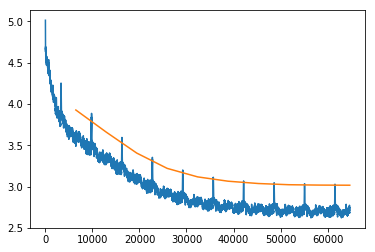

In [47]:
if TRAIN:
    learn.recorder.plot_losses()

### Model Output

In [48]:
if TRAIN: pass
MODEL_OUTPUT_NAME = MODEL_PATH/'models'/f'{model_name}_best.pth'
CLOUD_STORAGE = f'gs://w210-capstone/models/{model_name}_best.pth'

In [49]:
!gsutil cp $MODEL_OUTPUT_NAME $CLOUD_STORAGE

Copying file://../data/models/4.3-MM-108k-post-genre-song_title/models/4.3-MM-108k-post-genre-song_title_best.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/183.2 MiB.                                    


In [50]:
ARCHITECTURE_PATH = MODEL_PATH/'models'/f'{model_name}_architecture.pkl'
ARCHITECTURE_STORAGE = f'gs://w210-capstone/models/{model_name}_architecture.pkl'
ITOS_PATH = MODEL_PATH/'tmp'/'itos.pkl'
ITOS_STORAGE = f'gs://w210-capstone/models/{model_name}_itos.pkl'

model_dump = learn.model
with open(ARCHITECTURE_PATH, 'wb') as f:
    pickle.dump(model_dump, f)

In [51]:
!gsutil cp $ARCHITECTURE_PATH $ARCHITECTURE_STORAGE

Copying file://../data/models/4.3-MM-108k-post-genre-song_title/models/4.3-MM-108k-post-genre-song_title_architecture.pkl [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/369.2 MiB.                                    


In [52]:
!gsutil cp $ITOS_PATH $ITOS_STORAGE

Copying file://../data/models/4.3-MM-108k-post-genre-song_title/tmp/itos.pkl [Content-Type=application/octet-stream]...
/ [1 files][310.2 KiB/310.2 KiB]                                                
Operation completed over 1 objects/310.2 KiB.                                    


## Text Generation

In [53]:
def generate_step(learner, context, audio, context_length, temp=1):
    
    # FIX THIS
    audio_size = train_audio.feature_size

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()

    if audio is None:
        audio_features = Tensor([0]*audio_size*len(context))\
        .view(-1, 1, audio_size).cuda()
    else:
        audio_features = np.tile(audio, len(context))
        audio_features = Tensor(audio_features).view(-1, 1, len(audio)).cuda()
        
    # forward pass the "context" into the model
    result, *_ = model(context, audio_features)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def get_word_from_index(idx):

    return data_lm.valid_ds.vocab.textify([idx])


def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = 'xeol \n'
        elif 'xbol' in word:
            word = 'xbol'
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], audio=None, max_len=500, GPU=False, context_length=20, beam_width=5, temp=1, verbose=True, graph=False):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    if graph:
        optimization_graph = Digraph()

    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in range(max_len):
        print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, audio, context_length, temp)

            # Multinomial draw from the probabilities
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = np.argwhere(multinom_draw != 0).flatten()
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
                
                if graph:
                    optimization_graph.node("%d_%d" % (word_number, next_word_idx), "%s (%.2f)" % (get_word_from_index(next_word_idx), candidate[1]))
                    optimization_graph.edge("%d_%d" % (word_number - 1, context[len(context) -1]), "%d_%d" % (word_number, next_word_idx))
                
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries

        context_and_scores = context_and_scores[:15] #for now, only keep the top 15 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')

    if graph:
        now = str(datetime.datetime.now())
        optimization_graph.render(directory='graph_viz/', filename=now, cleanup=True)
    return context_and_scores
    

In [113]:
from pandas.io.json import json_normalize

data_model =   {
      "danceability": 0.6027456183070403,
      "duration_ms": 0.5962133916683182,
      "energy": 0.14658129805029452,
      "genres": [
        "folk",
        "gipsy"
      ],
      "mode": 0,
      "tags": [
        "tags",
        "tags"
      ],
      "tempo": 0.5637376656633328,
      "title": "title",
      "year": 1465
    }

df = json_normalize(data_model)

df.rename(columns={'duration_ms':'duration'}, inplace=True)
df['loudness'] = -3
df['time_signature'] = 4
df['key'] = 1

# ['tempo', 'mode', 'duration', 'key', 'loudness', 'time_signature']

audio_features = preprocessor.transform(df).flatten()

In [118]:
final_scores = generate_text(learn, GPU=GPU,
                             seed_text='xbos xgenre',
                             audio=audio_features,
                             max_len=60, context_length=40,
                             beam_width=3, verbose=False,
                             temp=1.5, graph=False)

Generating word: 1 / 60
Generating word: 2 / 60
Generating word: 3 / 60
Generating word: 4 / 60
Generating word: 5 / 60
Generating word: 6 / 60
Generating word: 7 / 60
Generating word: 8 / 60
Generating word: 9 / 60
Generating word: 10 / 60
Generating word: 11 / 60
Generating word: 12 / 60
Generating word: 13 / 60
Generating word: 14 / 60
Generating word: 15 / 60
Generating word: 16 / 60
Generating word: 17 / 60
Generating word: 18 / 60
Generating word: 19 / 60
Generating word: 20 / 60
Generating word: 21 / 60
Generating word: 22 / 60
Generating word: 23 / 60
Generating word: 24 / 60
Generating word: 25 / 60
Generating word: 26 / 60
Generating word: 27 / 60
Generating word: 28 / 60
Generating word: 29 / 60
Generating word: 30 / 60
Generating word: 31 / 60
Generating word: 32 / 60
Generating word: 33 / 60
Generating word: 34 / 60
Generating word: 35 / 60
Generating word: 36 / 60
Generating word: 37 / 60
Generating word: 38 / 60
Generating word: 39 / 60
Generating word: 40 / 60
Generatin

In [119]:
#print all of the final options of songs
for song, score in final_scores:
    print_words(song)
    print(score)
    print('\n')

xbos xgenre downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs 1.431734304170443


xbos xgenre colorá' downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs downstairs d

In [33]:
%load_ext autoreload
%autoreload 2

In [34]:
from src.nlp.generate_lyrics import DeepLyric

In [35]:
deep_lyric = DeepLyric(learn.model, weights=None, itos=data_lm.train_ds.vocab.itos)

In [ ]:
deep_lyric.

In [55]:
deep_lyric.generate_text(seed_text='xbos xgenre country', 
                         verbose=1, context_length=100, beam_width=3,
                         max_len=50, top_k=5, temperature=1.45,
                         GPU=True)

Generating word: 1 / 50
Generating word: 2 / 50
Generating word: 3 / 50
Generating word: 4 / 50
Generating word: 5 / 50
Generating word: 6 / 50
Generating word: 7 / 50
Generating word: 8 / 50
Generating word: 9 / 50
Generating word: 10 / 50
Generating word: 11 / 50
Generating word: 12 / 50
Generating word: 13 / 50
Generating word: 14 / 50
Generating word: 15 / 50
Generating word: 16 / 50
Generating word: 17 / 50
Generating word: 18 / 50
Generating word: 19 / 50
Generating word: 20 / 50
Generating word: 21 / 50
Generating word: 22 / 50
Generating word: 23 / 50
Generating word: 24 / 50
Generating word: 25 / 50
Generating word: 26 / 50
Generating word: 27 / 50
Generating word: 28 / 50
Generating word: 29 / 50
Generating word: 30 / 50
Generating word: 31 / 50
Generating word: 32 / 50
Generating word: 33 / 50
Generating word: 34 / 50
Generating word: 35 / 50
Generating word: 36 / 50
Generating word: 37 / 50
Generating word: 38 / 50
Generating word: 39 / 50
Generating word: 40 / 50
Generatin

In [56]:
deep_lyric.print_lyrics()

SONG START
 genre: country 
 title: the kiss of gold 

xbol-1 when i 'm with you 
 there 's so much out there for me 
 here and now , my dear 
 there is nothing more left to do 
 
 when my whole life through 
 i 

In [57]:
deep_lyric.save_lyrics_to_file('test.txt')

In [59]:
for i in range(10):
    deep_lyric.generate_text(max_len=20)
    deep_lyric.save_lyrics_to_file(f'test{i}.txt', GPU=True)

Generating word: 1 / 20


RuntimeError: Expected object of backend CUDA but got backend CPU for argument #3 'index'